# Automatic Noise Detection for Ambulatory Electrocardiogram in Presence of Ventricular Arrhythmias: application-ready models for low-power systems

Imports:

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, matthews_corrcoef
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
from sklearn.inspection import permutation_importance
import m2cgen
import re

from noiseIdxDB_utils import load_noiseIdxDB_features, compute_noiseIdxDB_sample_weights, get_performance_metrics

Reading the database and definition of sample weights

In [3]:
X, y, a, featureNames, labelNames, subject_ids = load_noiseIdxDB_features()
w = compute_noiseIdxDB_sample_weights(a, y)
nof = 5  # number of outer folds
outer_cv = GroupKFold(n_splits=nof)
inner_cv = GroupKFold(n_splits=3)

Noise index database: 163896 samples, 27 features 
Shape of main outcome y: (163896,)
Normal ECG records: 111353, weight = 1
Noise records: 33721, weight = 3.3021855816850034
Records of ECG with ventricular arrhythmias: 10768, weight = 10.341103268945023
Records of ECG with supraventricular tachycardias: 8054, weight = 13.825800844300968


**Decision tree**

Loading save decision trees

In [4]:
results_full, params_full, models_full = joblib.load(f"results_dt.joblib")

 Visualizing the feature importance of the best decision tree on each outer test fold:

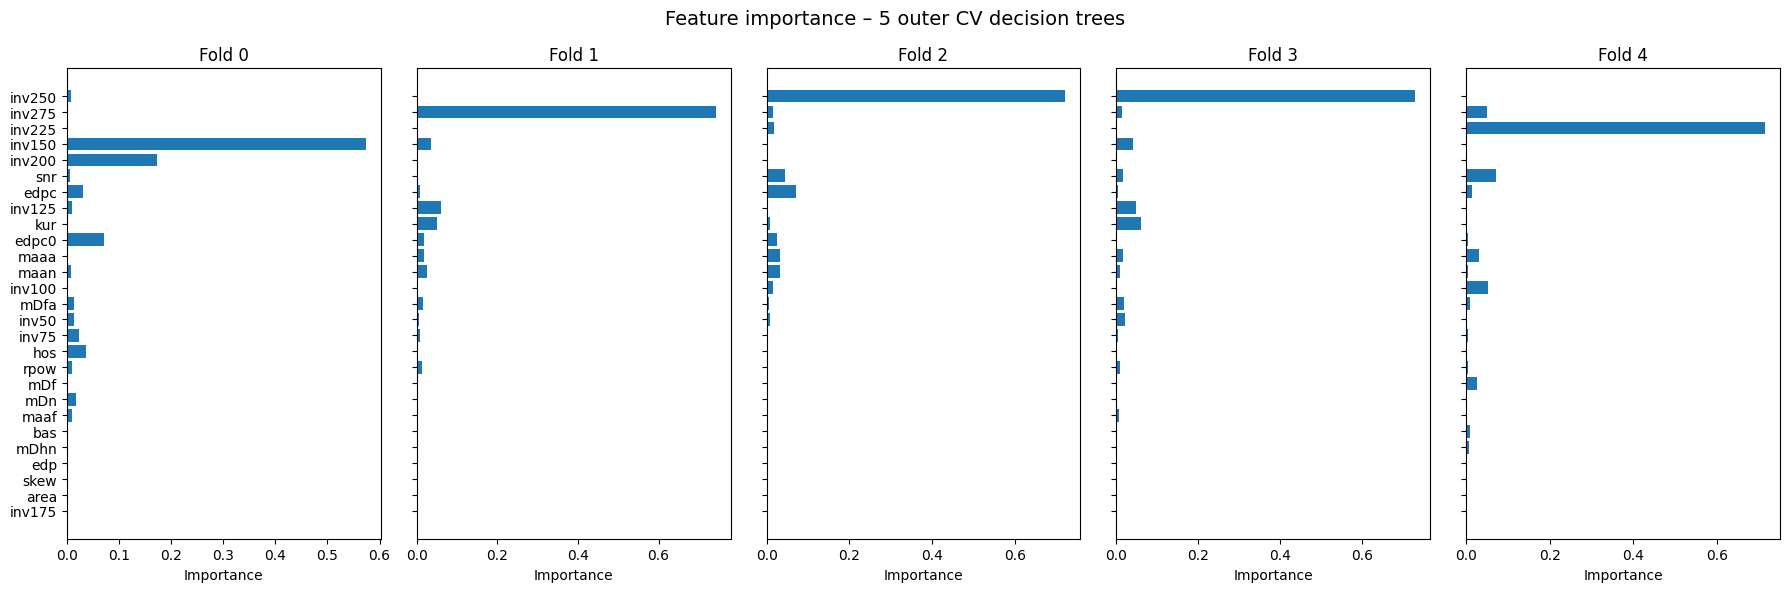

In [4]:
importances = np.vstack([m.feature_importances_ for m in models_full])
mean_importance = importances.mean(axis=0)
indices = np.argsort(mean_importance)[::-1]

# plot feature importance for each outer fold in a subplot
fig, axes = plt.subplots(1, nof, figsize=(18, 6), sharey=True)

# number of features
nf = X.shape[1]
for i, ax in enumerate(axes):
    ax.barh(
        range(nf),
        importances[i, indices][::-1]
    )
    ax.set_title(f"Fold {i}")
    ax.set_xlabel("Importance")
    ax.set_yticks(range(nf))
    ax.set_yticklabels([featureNames[j] for j in indices][::-1])

plt.suptitle("Feature importance – 5 outer CV decision trees", fontsize=14)
plt.tight_layout()
plt.show()

Reduced feature set:

In [5]:
# Features were selected based on 1) feature importance from outer CV
# 2) domain knowledge, and 3) computational budget of the target device
target_features = ['inv250', 'inv150','kur','edpc','maaa','mDfa','maan','snr']
target_idx = [i for i, name in enumerate(featureNames) if name in target_features]
print("Indexes of selected features: " + str(target_idx))
X_reduced = X[:,target_idx]

Indexes of selected features: [4, 8, 14, 15, 17, 19, 20, 26]


Training decision trees using learned hyperparameters and reduced feature set:

In [6]:
param_grid = {
    'max_leaf_nodes' : [20],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=0),
    param_grid=param_grid,
    scoring=make_scorer(matthews_corrcoef), # use Matthews correlation coefficient as scoring metric
    cv=inner_cv,
    refit=True,
    n_jobs=-1
)

outer_MCC = []
outer_sens = []
outer_spec = []
outer_spec_v = []
models = []
params = []

fold_idx = 0
print("Training a decision tree with nested cross validation ...")
for train_idx, test_idx in outer_cv.split(X_reduced, y, groups=subject_ids):
    
    fold_idx = fold_idx+1
    print("Outer fold " + str(fold_idx) + " ...")
    grid.fit(X_reduced[train_idx], y[train_idx], sample_weight=w[train_idx], groups = subject_ids[train_idx])
    params.append(grid.best_params_)

    y_test = y[test_idx]
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_reduced[test_idx])

    # get performance metrics
    a_test = a[test_idx]
    MCC, sens, spec, spec_v = get_performance_metrics(y_test, y_pred, a_test)
    outer_MCC.append(MCC)
    outer_sens.append(sens)
    outer_spec.append(spec)
    outer_spec_v.append(spec_v)
    
    models.append(best_model)

print("Outer CV MCC scores:", outer_MCC)
print("Mean outer MCC:", np.mean(outer_MCC))
print("Mean outer CV sensibility:", np.mean(outer_sens))
print("Mean outer CV specificity:", np.mean(outer_spec))
print("Mean outer CV specificity on records of ECG with ventricular arrhythmias:", np.mean(outer_spec_v))

# save results
results = {
    "mcc": outer_MCC,
    "sens": outer_sens,
    "spec": outer_spec,
    "spec_v": outer_spec_v
}

Training a decision tree with nested cross validation ...
Outer fold 1 ...
Outer fold 2 ...
Outer fold 3 ...
Outer fold 4 ...
Outer fold 5 ...
Outer CV MCC scores: [0.6466425664226184, 0.7706719088494135, 0.7761137196194936, 0.825192474858221, 0.8375919655508921]
Mean outer MCC: 0.7712425270601277
Mean outer CV sensibility: 0.8155522070515492
Mean outer CV specificity: 0.9577779411853504
Mean outer CV specificity on records of ECG with ventricular arrhythmias: 0.9192448208615094


Comparison between decision trees with full and reduced feature set:

In [7]:
metric_names = ["MCC", "Se", "Sp", "SpV"]
metric_names0 = ["mcc", "sens", "spec", "spec_v"]
rows = {}
rows["feature_set"] = ["full"] * 5 + ["reduced"] * 5
for idx in range(len(metric_names)):
    rows[metric_names[idx]]= list(map(float,results_full[metric_names0[idx]] + results[metric_names0[idx]]))
df = pd.DataFrame(rows)

summary = df.groupby('feature_set').agg(
    MCC=("MCC", lambda x: f"{x.mean():.2f} ± {x.std():.2f}"),
    Se=("Se",  lambda x: f"{x.mean():.2f} ± {x.std():.2f}"),
    Sp=("Sp",  lambda x: f"{x.mean():.2f} ± {x.std():.2f}"),
    SpV=("SpV",  lambda x: f"{x.mean():.2f} ± {x.std():.2f}")
)
print(summary)

                     MCC           Se           Sp          SpV
feature_set                                                    
full         0.79 ± 0.06  0.81 ± 0.08  0.96 ± 0.02  0.92 ± 0.05
reduced      0.77 ± 0.08  0.82 ± 0.05  0.96 ± 0.02  0.92 ± 0.05


The MCC of the model on the reduced feature set is slightly lower, although average sensitivity slightly increases. The lower MCC is to be to be attributed to a higher imbalance between false positives and false negatives.

Hyperparameters of each best decision tree on outer test folds:

In [8]:
depths = [p['max_leaf_nodes'] for p in params]
min_leaf = [p['min_samples_leaf'] for p in params]
min_split = [p['min_samples_split'] for p in params]
crits = [p['criterion'] for p in params]
max_feats = [p['max_features'] for p in params]

print("Max depths per fold:", depths)
print("Min samples leaf per fold:", min_leaf)
print("Min samples split per fold:", min_split)
print("Criteria per fold:", crits)
print("Max features per fold:", max_feats)

Max depths per fold: [20, 20, 20, 20, 20]
Min samples leaf per fold: [1, 1, 1, 1, 1]
Min samples split per fold: [2, 2, 2, 2, 2]
Criteria per fold: ['gini', 'gini', 'gini', 'gini', 'gini']
Max features per fold: [None, None, None, 'log2', 'log2']


Training a single, final decision tree using learned hyperparameters:

Final tree MCC: 0.8173987384766113
Final tree sensibility: 0.8403665371726817
Final tree specificity: 0.9670443633570194
Final tree specificity on records of ECG with ventricular arrhythmias: 0.9431649331352154


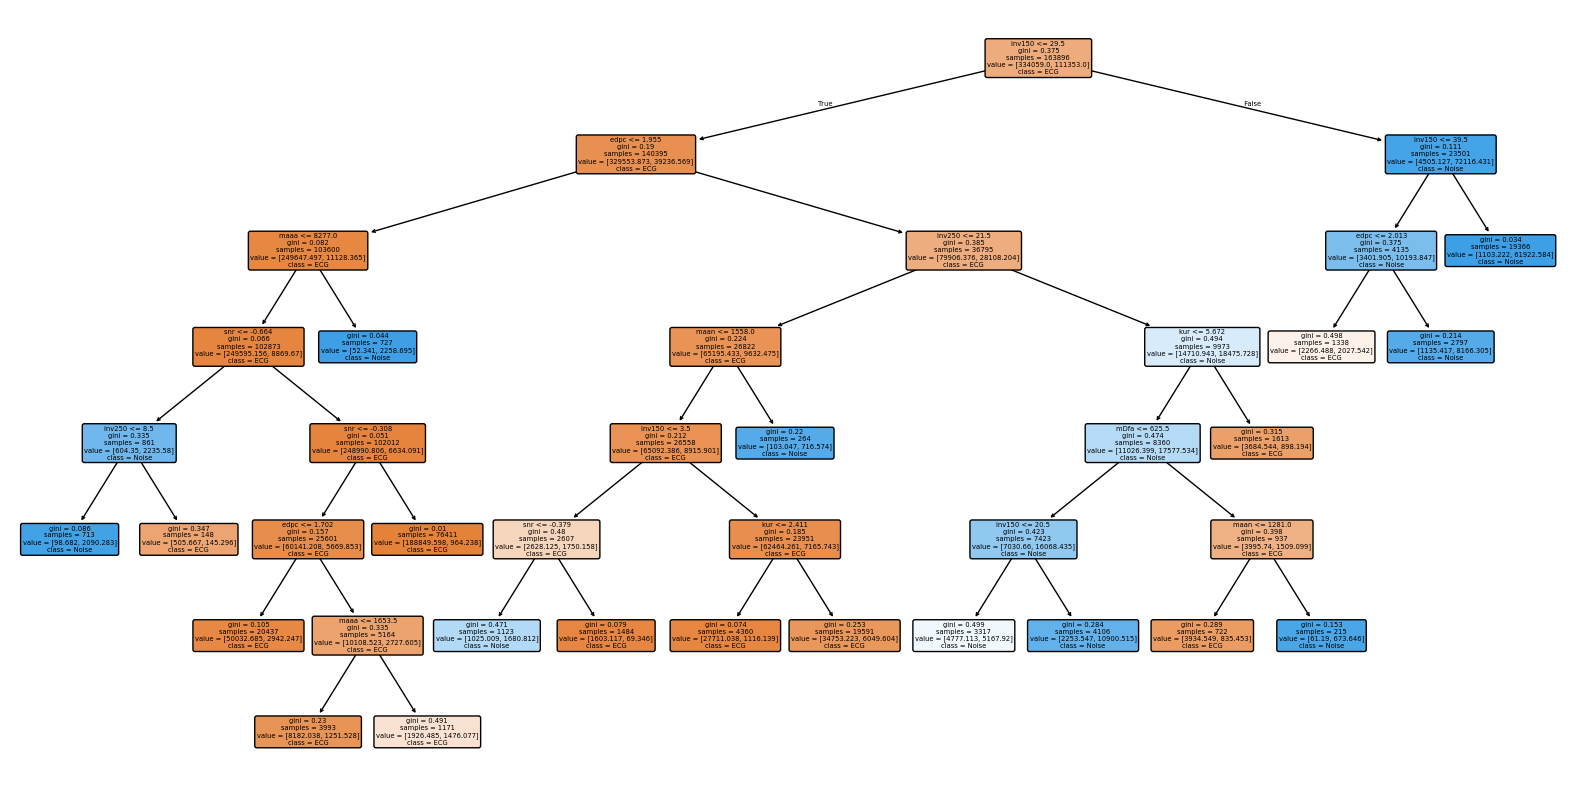

In [9]:
final_params = {
    'max_leaf_nodes' : 20,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'criterion': 'gini',
    'max_features': None
}

# train the final model
final_tree = DecisionTreeClassifier(**final_params)
final_tree.fit(X_reduced, y, sample_weight=w)
y_pred = final_tree.predict(X_reduced)

# get performance metrics
MCC, sens, spec, spec_v = get_performance_metrics(y, y_pred, a)

print("Final tree MCC:", MCC)
print("Final tree sensibility:", sens)
print("Final tree specificity:", spec)
print("Final tree specificity on records of ECG with ventricular arrhythmias:", spec_v)

results = {
        "mcc": MCC,
        "sens": sens,
        "spec": spec,
        "spec_v": spec_v
    }

joblib.dump((final_tree, results), "final_dt.joblib")

plt.figure(figsize=(20, 10))
plot_tree(
    final_tree,
    feature_names=target_features,
    class_names=["ECG", "Noise"],   # o le tue classi
    filled=True,
    rounded=True
)
plt.show()

Turning the trained decision tree into C++ code:

In [ ]:
cpp_code = m2cgen.export_to_c(
    final_tree,
    # the class CNoisePredictionModel was previously defined in NoisePredictionModel.h
    function_name="CNoisePredictionModel::DecisionTree"
)
code = f"""
#include "NoisePredictionModel.h"
{cpp_code}
CNoisePredictionModel::CNoisePredictionModel() {{}}
CNoisePredictionModel::~CNoisePredictionModel() {{}}
"""

# Fix MSVC issues (C99 literals are not handled well by Visual Studio)
pattern = r'memcpy\(\s*(\w+)\s*,\s*\(double\[\]\)\s*\{([^}]*)\}\s*,\s*(\d+)\s*\*\s*sizeof\(double\)\s*\)\s*;'

def replace_memcpy(match):
    var_name = match.group(1)
    values = match.group(2)
    count = match.group(3)
    return f'{{ double temp[{count}] = {{{values}}}; memcpy({var_name}, temp, {count} * sizeof(double)); }}'
def convert_double_to_float(code):
    code = code.replace('double', 'float')
    code = code.replace('sizeof(float)', 'sizeof(float)')
    return code

fixed_code = re.sub(pattern, replace_memcpy, code)
fixed_code = convert_double_to_float(fixed_code)

with open("NoisePredictionModel.cpp", "w") as f:
    f.write(fixed_code)

Training a (very) shallow **neural network** (NN):

In [10]:
param_grid = {
    "mlp__hidden_layer_sizes": [(4,), (8,), (16,)],
    "mlp__alpha": [1e-4, 1e-3, 1e-2]
}

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPClassifier(
        activation="tanh",
        solver="adam", # the default method, 'adam' works generally well
        learning_rate="adaptive", # default is 'constant'
        early_stopping=True,  # regularization to prevent overfitting
        validation_fraction=0.15, # fraction of training data to set aside as validation set for early stopping
        n_iter_no_change=20, # number of epochs with no improvement to wait before stopping
        max_iter=500, # should be enough for convergence with early stopping
        random_state=42
    ))
])

param_grid = {
    "mlp__hidden_layer_sizes": [(4,), (8,), (16,)],
    "mlp__alpha": [1e-4, 1e-3, 1e-2]
}

grid = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=outer_cv,
    scoring=make_scorer(matthews_corrcoef),  # or MCC
    n_jobs=os.cpu_count()-2, # avoid using all cores
    refit=True # refit the best model on the whole dataset
)

grid.fit(X_reduced, y, mlp__sample_weight=w, groups=subject_ids)
model = grid.best_estimator_
y_pred = model.predict(X_reduced)

# get performance metrics
MCC, sens, spec, spec_v = get_performance_metrics(y, y_pred, a)
results = {
        "mcc": MCC,
        "sens": sens,
        "spec": spec,
        "spec_v": spec_v
    }

print("Final MLP MCC:", MCC)
print("Final MLP sensibility:", sens)
print("Final MLP specificity:", spec)
print("Final MLP specificity on records of ECG with ventricular arrhythmias:", spec_v)

print("Best MLP parameters:", grid.best_params_)

joblib.dump((grid, results), "final_mlp.joblib")

Final MLP MCC: 0.8798188455590882
Final MLP sensibility: 0.9165505174816879
Final MLP specificity: 0.9716381793739197
Final MLP specificity on records of ECG with ventricular arrhythmias: 0.9629457652303121
Best MLP parameters: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (16,)}


['final_mlp.joblib']

Comparison between the two final models:

In [7]:
(grid, results_mlp) = joblib.load("final_mlp.joblib")
(final_tree, results_dt) = joblib.load("final_dt.joblib")

df = pd.DataFrame({
    'DT': results_dt,
    'MLP': results_mlp
})
print(df.T)

          mcc      sens      spec    spec_v
DT   0.817399  0.840367  0.967044  0.943165
MLP  0.879819  0.916551  0.971638  0.962946


Inspecting the neural network:

In [7]:
pipeline = grid.best_estimator_
mlp = pipeline.named_steps['mlp']

print("Hidden layers:", mlp.hidden_layer_sizes)
print("Activation:", mlp.activation)
print("Number of iterations:", mlp.n_iter_)
print("Early stopping:", mlp.n_iter_ < mlp.max_iter)

for i, (W, b) in enumerate(zip(mlp.coefs_, mlp.intercepts_)):
    print(f"Layer {i}:")
    print("  Weights shape:", W.shape)
    print("  Biases shape:", b.shape)

Hidden layers: (16,)
Activation: tanh
Number of iterations: 107
Early stopping: True
Layer 0:
  Weights shape: (8, 16)
  Biases shape: (16,)
Layer 1:
  Weights shape: (16, 1)
  Biases shape: (1,)


Permutation feature importance

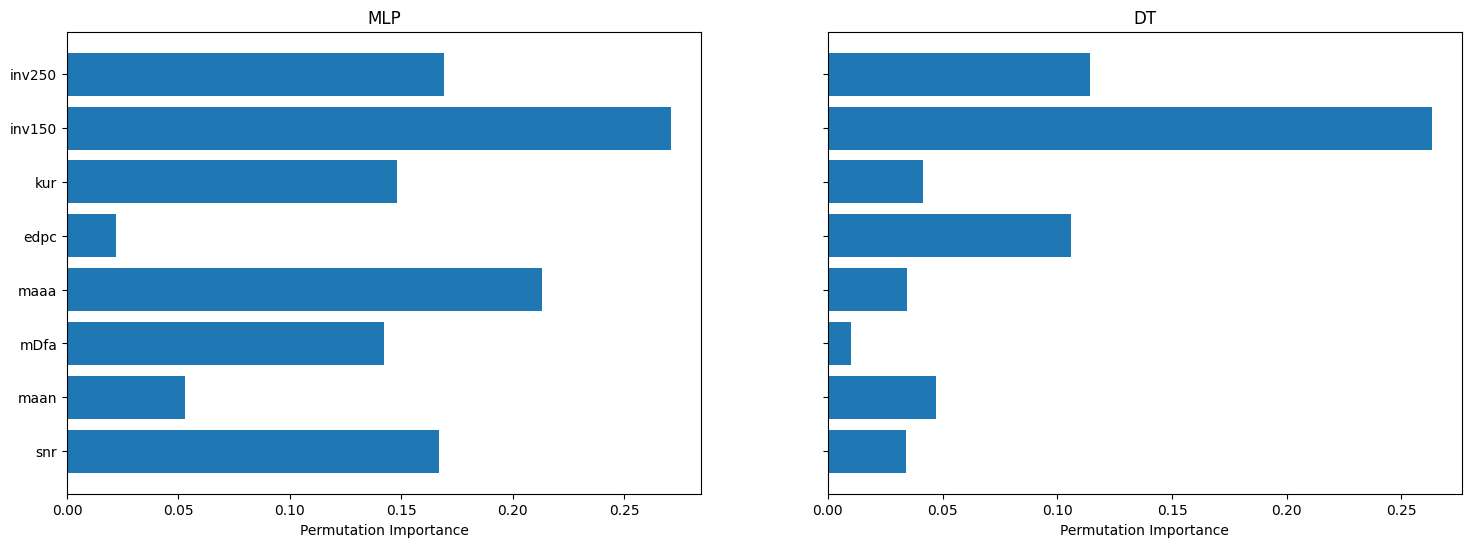

In [13]:
r = permutation_importance(
    pipeline,
    X_reduced,
    y,
    scoring=make_scorer(matthews_corrcoef),
    n_repeats=5,
    random_state=42
)
importances_mlp = r.importances_mean
r = permutation_importance(
    final_tree,
    X_reduced,
    y,
    scoring=make_scorer(matthews_corrcoef),
    n_repeats=5,
    random_state=42
)
importances = np.vstack([importances_mlp,r.importances_mean])

# Plot permutation importance
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)
for i, ax in enumerate(axes):
    ax.barh(
        range(len(target_features)),
        importances[i][::-1]
    )
    if i == 0:
        ax.set_title("MLP")
    else:
        ax.set_title("DT")
    ax.set_xlabel("Permutation Importance")
    ax.set_yticks(range(len(target_features)))
    ax.set_yticklabels([target_features[j] for j in range(len(target_features))][::-1])


The 'inv150' feature is the most useful feature for both models. However, the MLP model relies onthe information contento of a wider set of features, while the DT model is focused on the inv150, inv250, and edpc features alone.